In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm

<h1>Logistic Regression: StatsModels and Details of Regression</h1>

We can do some more logitic regression to make classification predictions, there's some things that we do to try to drive accuracy up, and some other work we can do to interpret the accuracy better. 

In [3]:
#Read diabetes data
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


<h2>Baseline Accuracy</h2>

Before we get going, we'll touch on a simple concept - the baseline accuracy. For example, in post WW2 Germany the ratio of males to females was approximately .6 (3:5) for people in their 20s - or approximately 5/8 or 62.5% of people were females. 

If we were to build some model to predict if a twenty-soemthing was a male or female, this should be the worst we can do. A 'default' model of always guessing female will be 62.5% accurate, so if we can't beat that, we suck and are useless. 

In [5]:
#baseline for diabetes
1 - df["Outcome"].mean()

0.6510416666666667

So... a model guessing NO at all times would be ~65% accurate here, so that's our worst case scenario. 

<h2>StatsModels Formula Based Logistic Regression</h2>

The book uses the forumla method for calling statsmodels, whereas when we did linear regression, we used the 'regular' way. For logistic regression, we can try using the formula here. As with linear regression, statsmodels gives us some more detailed data that we can look at to try to understand the effectiveness of the model, such as p values for each feature. 

Like linear regression, scikitlearn vs statsmodels vs any other library function is pretty much up to you. They do the same thing, so use what you please. SKlearn is a little more transferable to future uses in terms of mechanics. 

With the statsmodels formula, we can save a little bit of data manipulation in exchange for writing out the feature names. Most notably, we can keep the Xs and Y together in the data, then when we write the formula, that does the 'splitting'. 

In [6]:
#Split data - we are keeping the DF to make the results nice
#If doing a dataframe, there's no x/y split. So we basically cut the function in half
test1, train1 = train_test_split(df,test_size=0.3)


<h3>Statsmodels Formula</h3>

The formual for statsmodels is relatively simple. The format is:

Y ~ x1 + x2 + x3....

Then we feed the logit formula the dataframe to use as well as the formula that tells it which columns go where. After that, it is the same. 

In [7]:
#Define formula
form = "Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age"
model1 = sm.logit(data=train1, formula=form).fit()

#Make predictions for later, get summary for now
preds1 = model1.predict(test1)
model1.summary()

Optimization terminated successfully.
         Current function value: 0.404131
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  231
Model:                          Logit   Df Residuals:                      222
Method:                           MLE   Df Model:                            8
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                  0.3651
Time:                        14:12:34   Log-Likelihood:                -93.354
converged:                       True   LL-Null:                       -147.03
Covariance Type:            nonrobust   LLR p-value:                 1.326e-19
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -10.3449      1.541     -6.713      0.000     -13.365      -7.324
Pregnancies                  0.0612      0.066      0.930      0.352      -0.068       0.190
Glucose                      0.0430      0.008      5.467      0.000       0.028       0.058
BloodPressure               -0.0279      0.011     -2.454      0.014      -0.050      -0.006
SkinThickness               -0.0053      0.015     -0.366      0.715      -0.034       0.023
Insulin                     -0.0027      0.002     -1.602      0.109      -0.006       0.001
BMI                          0.1358      0.032      4.193      0.000       0.072       0.199
DiabetesPedigreeFunction    -0.1960      0.515     -0.381      0.703      -1.205       0.813
Age                          0.0558      0.020      2.856      0.004       0.018       0.094
============================================================================================
"""

In [8]:
#Get the head of the predictions. #how likely they are to be diabetic
preds1.head()

459    0.819212
538    0.137854
217    0.227891
180    0.027947
713    0.081830
dtype: float64

Predictions give us the probabilities, we need to convert to 0-1 to give 'real' answers. We'll make a function:

In [9]:
#Convert the probabilities to yes/no correctness
def convert_prob_to_label(prob, cutoff = 0.5):
    label = []
    for i in range(len(prob)):
        if prob[i] > cutoff:
            label.append(1)
        else:
            label.append(0)
    return label

In [10]:
labels = convert_prob_to_label(np.array(preds1))
labels[0:5]

[1, 0, 0, 0, 0]

<AxesSubplot:>

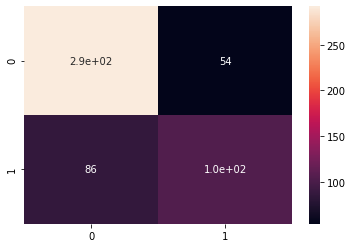

In [11]:

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test1["Outcome"], labels)
sns.heatmap(conf_matrix, annot=True)

In [12]:
#Create calc for misclassification rate. 
#We can look this up, but it is just adding up the errors and dividing. 
#The confusion matrix is an array, so we just need to grab the correct cells. 
#The is the compliment to the accuracy score, so we can just use library functions in general
mis_rate = (conf_matrix[[1],[0]].flat[0] + conf_matrix[[0],[1]].flat[0])/len(test1)
print(mis_rate)
print(accuracy_score(test1["Outcome"], labels))


0.260707635009311
0.7392923649906891


Now, the accuracy is ok, but we have a noticable imbalance between false negatives and false positives (exact split we bounce around due to randomness - when I built this the frist run was pretty large, other runs were smaller). We previously looked briefly at all the different accuracy metrics that can be generated from the confusion matrix. In real use, you need to combine some domain knowledge with these results to choose the measures that make sense for what you're doing. 

<h3>F1 Score</h3>

There is one score that is pretty common that may be helpful  - the F1 score. The F1 score seeks to balance PRECISION (avoid false positives) and RECALL (target true positives, at cost of false positives). There's also a way (fbeta) to adjust the balance between recall and precision, but we'll set that aside for now. The f1 score is:

F1 = 2 * ( (precision * recall) / (precision + recall) )

In practice, it is simple with an sklearn function. 

<h3>Side Note: Other Metrics</h3>

Below the F1, I put in log-loss, which is another metric of accuracy. This one is commonly seen later on when doing neural network stuff. The idea is always the same - we want to find something that minimizes the amount of error. In a question on the credit card fraud I said that you may try to optimize for some other metric than raw accuracy - this is an example of one that is common. In short, you'll define a ML algorithm to use, then define a loss function (e.g. log-loss), and the algorithm will repeat trials (gradient descent) in an effort to minimize that "loss". 

Log Loss is the negative average of the log of corrected predicted probabilities for each instance. E.g. if a value is true, and a prediction is .8 probability, the corrected probability is .8; if a value is false and the prediction is .8 probability, the corrected proability is .2. These values are "logged", then the negative average is taken (the logs are negative), and that's the metric for loss - or how bad the predictions are. Less loss, more accuracy. This is also known as cross-entropy loss. Think back to the original look we took at error in the first look at logistic regression. 

This is what the internal process of the logistic regression is actually minimizing on each trial. 

In [13]:
#Can also use the accuracy score for sklearn. 
print("Acc%:", accuracy_score(test1["Outcome"], labels))
print("F1:", f1_score(test1["Outcome"], labels))
print("LogLoss:", log_loss(test1["Outcome"], preds1))

Acc%: 0.7392923649906891
F1: 0.6
LogLoss: 0.5493805638564151


Ok, roughly 77% accuracy. Put that in our pockets. 
<br><br>

<h2>Feature Scaling</h2>

Feature scaling includes several similar methods of taking numerical values and transforming them to be on a different scale. There are several, a few we'll look at right now are:
<ul>
<li>Normalization - rescale the data so all values are between 0 and 1. 
<li>Standardization - rescale the data so there is a mean of 0 and a standard deviation of 1. 
</ul>

These all process our data in a similar way - taking the original data, and shifting its distribution using a transformation. The calculations for these scaling methods are:
<ul>
<li>Normalization: x = ( (x-min(x)) / (max(x)-min(x)) )
<li>Standardization: x = ( (x-mean(x)) / (std(x)) )
</ul>

Note: There are other feature scaling algorithms/methods, these are just the two more common ones. The idea is pretty much always the same. One other consdieration is how the scaling treats outliers, which we'll worry about more next semester. 

<h3>OK.... Why?</h3>

Feature scaling has several benefits, the impact of these benefits varies widely depending on the exact original data, and the type of models you're using. The reasons are:
<ul>
<li>Scaling - different values may have widely different scales (e.g. if processing a loan, age and net worth will be very different). Scaling can sometimes cause problems with the relative impact of different ranges distorting calculations. Small values can be "drowned out" by larger values. 
<li>Range - similar to the scale problem, if data values are radically different, some calculations will become less accurate. This particularly can impact distance based calculations, like clustering. 
<li>Speed - with algorithms that use methods like gradient descent (like logistic regression), having values on different scales and ranges may cause the algorithm to take longer to converge on a solution, or potentially prevent it at all. 
</ul>

Feature scaling can improve predictive accuracy, sometimes dramatically. Scaling data is not super impactful in some calculations (linear regression, trees) and it can (can - not will) be very impactful in others (logistic regression, gradient descent, neural networks, PCA). In general, when we have an algorithm that is adjusting itself to try to find the most accurate solution (e.g. log. reg. with gradient descent), scaling the data helps and is pretty standard. When we get to things like neural networks later on, it is just part of the process. 

We will do this pretty often in machine learning applications, similar to encoding categorical varaibles it is kind of a preparatory step that we just do without thinking much about it because it makes things work (or work better).

<h3>Which Scaler to Pick?</h3>

There is not generally a definitive answer to that, and the real answer is to try a few and observe the results in accuracy. We do have a few rules of thumb:
<ul>
<li>Normalization: distribution is unkonwn, things need to be 0 to 1. 
<li>Standardization: distributions are normal. 
</ul>

For now deciding between the methods isn't a huge concern. If the features look normal, we'll try to standardize; if not, normalize. We can worry about some finer differences as they come up next semester. If in doubt, try each, check accuracy, choose the best. Outliers will impact each (think about why), so we probably want to deal with those prior to scaling. 

For fun, we can build a function for each, since they are simple. 

In [14]:
#Some example data
#d1 = [1,2,3,4,5,9,5,12,7,8,12,5,6,8,2,8,9]
#d2 = [1,2,3,4,5,9,5,12,7,12,5,6,8,2,8,9,800]
d1 = df["BMI"].to_list()
d2 = df["Glucose"].to_list()

In [15]:
#COMPLETE FUNCTION
def dumbNormalizer(x):
    x_ = (x - np.mean(x)) / (np.std(x))
    return x_


In [16]:
#Normalize some data
tmp = dumbNormalizer(d1)
print(np.mean(tmp))
print(tmp[0:5])

2.590520390792032e-16
[ 0.20401277 -0.68442195 -1.10325546 -0.49404308  1.4097456 ]


And now a dumb standardizer...

In [17]:
#COMPLETE FUNCTION
def dumbStandardizer(x):
    x_ = (x - np.mean(x))/np.std(x)
    return x_

In [18]:
#Standardize some data
tmp = dumbStandardizer(d1)
print(np.mean(tmp))
print(tmp[0:5])

2.590520390792032e-16
[ 0.20401277 -0.68442195 -1.10325546 -0.49404308  1.4097456 ]


<h3>How Does the Distribution Change?</h3>

We can visualize both datasets in their original form, after normalization, and after standardization. 

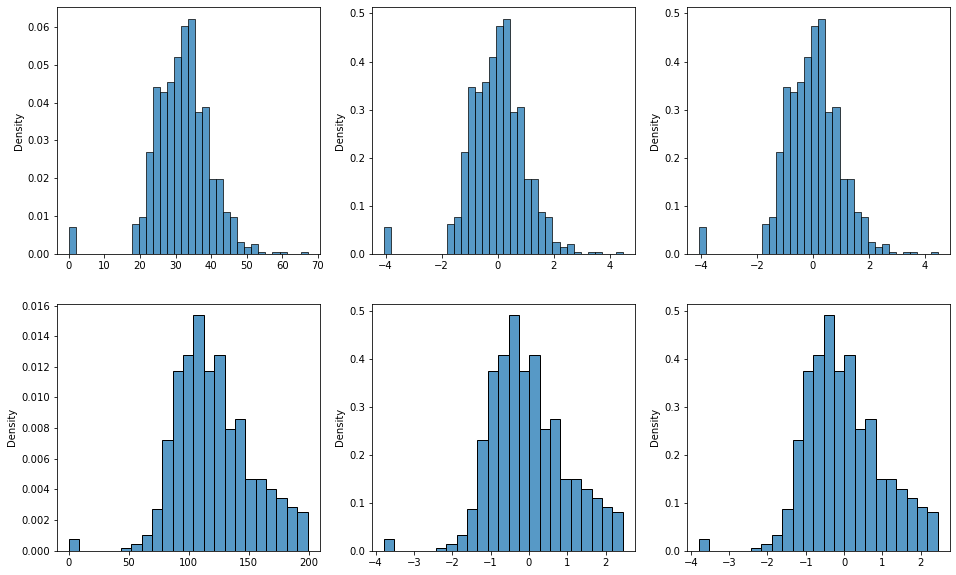

In [19]:
#Visualize all
thinkplot.PrePlot(6,2,3)
sns.histplot(d1, stat="density")
thinkplot.SubPlot(2)
sns.histplot(dumbNormalizer(d1), stat="density")
thinkplot.SubPlot(3)
sns.histplot(dumbStandardizer(d1), stat="density")
thinkplot.SubPlot(4)
sns.histplot(d2, stat="density")
thinkplot.SubPlot(5)
sns.histplot(dumbNormalizer(d2), stat="density")
thinkplot.SubPlot(6)
sns.histplot(dumbStandardizer(d2), stat="density")
thinkplot.Config()

<h3>Scaling Outcomes</h3>

For each of the scaling, the distribution is the same for the data after the transformation, but the range on the x scale is different. We can also see visually the impact of outliers here - we'd normally want to address those in advance. In extreme cases, having a massive outlier can "squish" all the data at one end of the distribution, which will be bad in most cases. 

<h4>Scaling Caveat</h4>

One detail we've overlooked here is that the data should technically be scaler after the split of train/test data, and the scaler should only be trained on the training data (fit) and applied on the testing data (transform). This is to prevent any data leakage - the test data is supposed to be brand new, and if it is able to influence the scaling, then it has some impact on the training of the model. How much of an impact does this make? Probabaly not much for the vast majority of applications, but it is technically correct to keep 'em separated. 

We'll do the below example with it scaled 'properly'. 

<h3>Library Scaling Functions</h3>

Luckily, we don't really need to bust out our algebra to build any of these calculations by hand, we can use some built in functions in scikit learn to do it for us. These functions can also be built into a pipeline to process data (next semester), so we can build this transformation in without really seeing the resutlts. Like encoding last week, this takes data that is readable, and makes it not readable - we can package all of those steps in with our modelling, so legible data goes in - a trained model comes out. 

In scikit learn, the different functions for these methods are (examples below in code):
<ul>
<li>Normalization: MinMaxScaler
<li>Standardization: StandardScaler
</ul>

<h3>Example with Real Functions</h3>

Building scaling functions is pretty easy, in practice though we can use the sklearn ones, lets build that into the logistic regression for the diabetes prediction. 

In [20]:
#Kill outliers. 
#We'll use this in a bit. 

df = df[df["Glucose"] > 20]
df = df[df["BloodPressure"] > 20]
df = df[df["SkinThickness"] < 80]
df = df[df["Glucose"] > 20]
df = df[df["BMI"] > 10]

In [21]:
#Make arrays from data
# Y = Outcome
# Xs = the other stuff
dfY = df["Outcome"]
dfX = df.drop(columns={"Outcome"}) #There isn't generally a need to standardize the Y values

x = np.array(dfX)
y = np.array(dfY).reshape(-1,1)
x.shape, y.shape

((723, 8), (723, 1))

In [22]:
#Split Data
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.33)

In [23]:
#Create scaler and choose method. 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Comment one out, use the other
scaler = StandardScaler()
#scaler = MinMaxScaler()

In [24]:
#Standardize or normalize
#Use training data to fit the scaler, then apply that predefined scale to the test data
x2 = scaler.fit_transform(X_train2)
X_trans2 = scaler.transform(X_test2)

We have standardized and normalized data, do linear regression stuff...

I'm going to set it up so we can swap the x data in the first line of code below, mostly to save typing. We can run everything twice, once for each scaling technique. 

In [25]:
#Train model
model2 = LogisticRegression().fit(x2,y_train2.ravel())

#Make predictions
preds2 = model2.predict(X_trans2)


F1: 0.6986301369863014
Acc: 0.8158995815899581


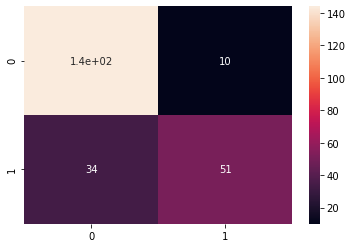

In [26]:
#Generate 1/0 results and show results
labels2 = convert_prob_to_label(np.array(preds2))
conf_matrix2 = confusion_matrix(y_test2,labels2)
sns.heatmap(conf_matrix2, annot=True)

print("F1:",f1_score(y_test2, labels2))
print("Acc:",accuracy_score(y_test2, labels2))

Yay. We are super happy. 

IIRC, the accuracy without doing any scaling was similar (~76%), that's ok. This data didn't really have any massively differing ranges for the original data. We also didn't do any outlier filtering - what if we try that and repeat? We know from doing the dumb scaling, that there are a few outliers. 

There's a simple filter commented out up above, we'll go remove and repeat. It might make it better, it might not. This case only has a few outliers and they are not outrageous, so we shouldn't be surprised if the difference is relatively small. We can see that the errors are more balanced, so the F1 score does show improvement. 

<H1>Logistic Regression with Normalization Exercise</H1>

Logistic regression with normalization. 

Identify penguin sex. In doing so:
<ul>
<li>Explore the data. 
<li>Clean any erroneous data. 
<li>Create classification model. 


In [27]:
df2 = sns.load_dataset("penguins")
df2.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Check data types. 

In [28]:
#DF Info/describe
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Check for missing values

In [45]:
#Check for missing values
df2.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [46]:
#Remove missing values
df2 = df2.dropna()
df2.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

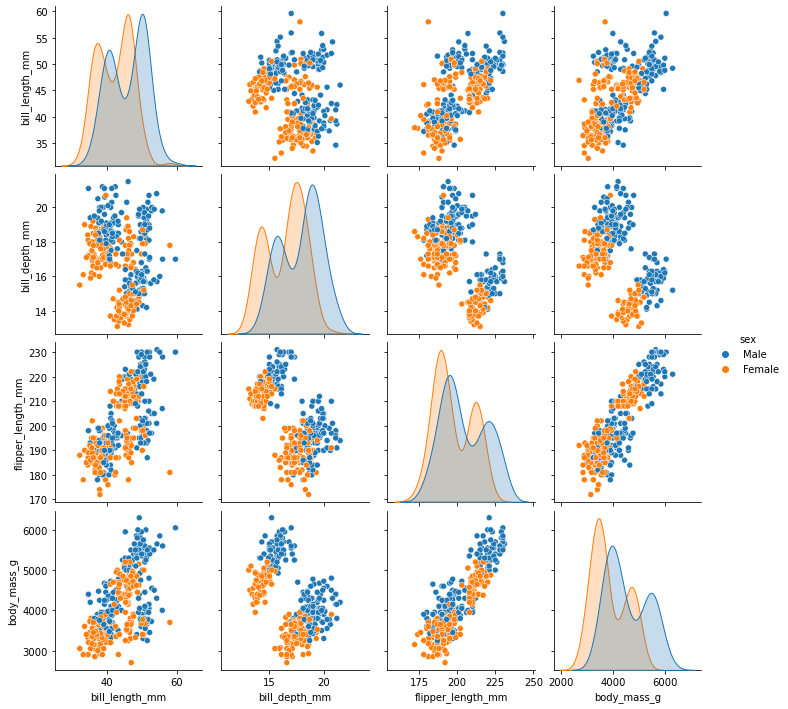

In [50]:
#Numerical value exploration
sns.pairplot(df2, hue='sex')

Numerical things look pretty OK. What about categorical?

<AxesSubplot:xlabel='island', ylabel='count'>

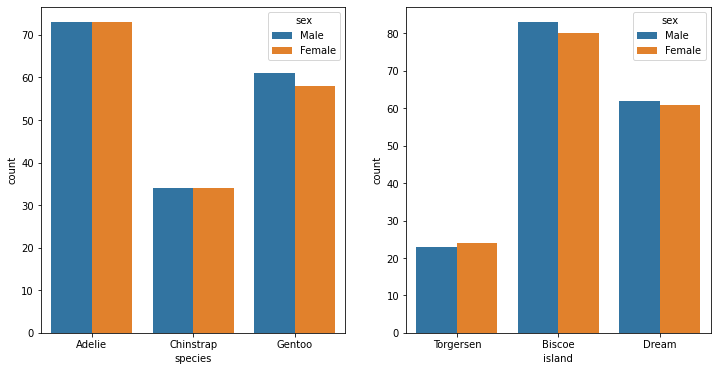

In [52]:
#Explore categorical data
thinkplot.PrePlot(2,1,2)
sns.countplot(data=df2, x='species', hue='sex')
thinkplot.SubPlot(2)
sns.countplot(data=df2, x='island', hue='sex')

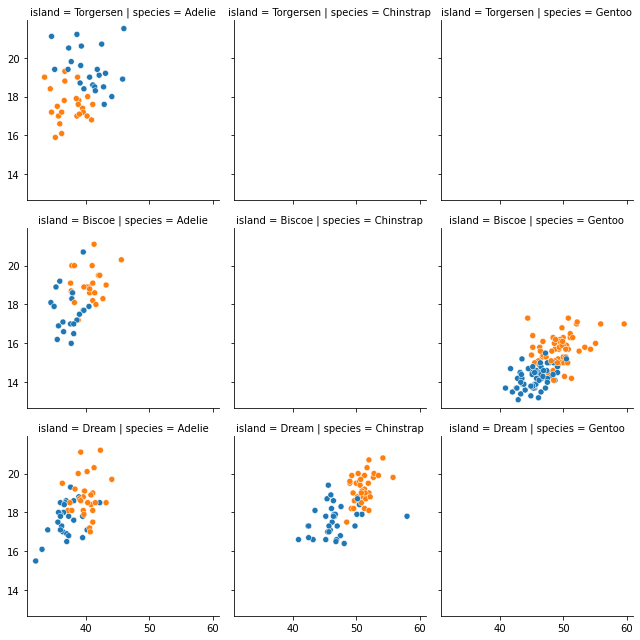

In [53]:
#Facetgrid allows us to explore and split data easily. 
#Could play with this for differnet views. https://seaborn.pydata.org/generated/seaborn.FacetGrid.html 
#Col and row in the first line are our categoricals.
#Second line is the type of chart, and its relevent details. 
g = sns.FacetGrid(df2, col="species", row="island")
g.map_dataframe(sns.scatterplot, x="bill_length_mm", y="bill_depth_mm", hue="sex")

Nothing looks too odd in the exploration (this is a toy dataset, so that's normal). We can do some modelling and predict sex...

I will sklearn, because I like it more. Statsmodels imight be useful in a bit, we could throw it in to get p values for the variables. 

In [55]:
#Encode the categorical varaiables. 
df2_ = pd.get_dummies(df2, drop_first=True)
df2_.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
0,39.1,18.7,181.0,3750.0,0,0,0,1,1
1,39.5,17.4,186.0,3800.0,0,0,0,1,0
2,40.3,18.0,195.0,3250.0,0,0,0,1,0
4,36.7,19.3,193.0,3450.0,0,0,0,1,0
5,39.3,20.6,190.0,3650.0,0,0,0,1,1


In [57]:
#Make arrays from new data
y = np.array(df2_['sex_Male']).reshape(-1,1)
x = np.array(df2_.drop(columns={'sex_Male'}))
y.shape, x.shape

((333, 1), (333, 8))

In [58]:
#Split Data
X_trainP, X_testP, y_trainP, y_testP = train_test_split(x, y, test_size=0.3)

In [61]:
#Scale data
#scalerP = StandardScaler()
scalerP = MinMaxScaler()

X_trainP_ = scalerP.fit_transform(X_trainP)
#Use training data to fit the scaler, then apply that predefined scale to the test data
X_testP_ = scalerP.transform(X_testP)


In [62]:
#Fit Model 
penguin = LogisticRegression().fit(X_trainP_, y_trainP.ravel())


In [63]:
#Compare to baseline accuracy
df2["sex"].value_counts()

Male      168
Female    165
Name: sex, dtype: int64

Baseline is roughly 50/50, how'd we do? 

F1: 0.9320388349514563
Acc: 0.93


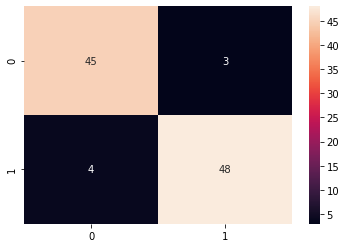

In [68]:
#Make predictions and examine accuracy
littlePenguins = penguin.predict(X_testP_)
labels2 = convert_prob_to_label(np.array(littlePenguins))
conf_matrixPenguin = confusion_matrix(y_testP,labels2)
sns.heatmap(conf_matrixPenguin, annot=True)

print("F1:",f1_score(y_testP, labels2))
print("Acc:",accuracy_score(y_testP, labels2))

We're doing pretty well. What could be better? 

One suspicion I have would be that the species are somewhat different. Gentoo in particular seems to have different metrics, so maybe we'd predict it separately? I might need more data for that. 

Also, can we improve by removing confounding vars? Look at StatsModels to have an idea of variable relevance. 

In [66]:
#Encode all data
dfP_ = pd.get_dummies(data=df2, drop_first=True)

In [67]:
#I'm not going to split data, all I want is variable importance, I'm not evaluating accuracy here. 
formP = "sex_Male ~ bill_length_mm + bill_depth_mm + flipper_length_mm + body_mass_g + species_Chinstrap + species_Gentoo + island_Dream + island_Torgersen"
modelP_SM = sm.logit(data=dfP_, formula=formP).fit()
modelP_SM.summary()

Optimization terminated successfully.
         Current function value: 0.189260
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               sex_Male   No. Observations:                  333
Model:                          Logit   Df Residuals:                      324
Method:                           MLE   Df Model:                            8
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                  0.7269
Time:                        14:47:44   Log-Likelihood:                -63.024
converged:                       True   LL-Null:                       -230.80
Covariance Type:            nonrobust   LLR p-value:                 1.090e-67
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -80.3767     12.330     -6.519      0.000    -104.544     -56.210
bill_length_mm        0.6144      0.132      4.656      0.000       0.356       0.873
bill_depth_mm         1.6464      0.336      4.903      0.000       0.988       2.305
flipper_length_mm     0.0267      0.048      0.552      0.581      -0.068       0.121
body_mass_g           0.0058      0.001      5.351      0.000       0.004       0.008
species_Chinstrap    -7.4027      1.663     -4.452      0.000     -10.661      -4.144
species_Gentoo       -8.4276      2.597     -3.245      0.001     -13.518      -3.337
island_Dream          0.3242      0.809      0.401      0.689      -1.262       1.910
island_Torgersen     -0.5079      0.856     -0.593      0.553      -2.185       1.169
=====================================================================================
"""

I'll remove island and flipper length, try again, and see what's up...

In [73]:
#Drop the things that look least useful. 
dfXP2 = df2_.drop(columns={"sex_Male", "flipper_length_mm", "island_Dream", "island_Torgersen"}) 

#Make arrays from new data, check shapes
xP2 = np.array(dfXP2)
xP2.shape, y.shape

((333, 5), (333, 1))

In [75]:
#Split Data
X_trainP2, X_testP2, y_trainP2, y_testP2 = train_test_split(xP2, y, test_size=0.3)

In [89]:
#Scale data
scalarP2 = MinMaxScaler()
x_scaled = scalerP.fit_transform(X_trainP2)
y_scaled = scalerP.transform(X_testP2)
#Use training data to fit the scaler, then apply that predefined scale to the test data

In [93]:
#Fit Model 
newpenguins = LogisticRegression().fit(X_trainP2, y_trainP2.ravel())


In [95]:
#Make predictions and examine accuracy
newlittlePenguins = newpenguins.predict(x_scaled)
labels2 = convert_prob_to_label(np.array(newlittlePenguins))
conf_matrixPenguin2 = confusion_matrix(y_testP2,labels2)
sns.heatmap(conf_matrixPenguin, annot=True)

print("F1:",f1_score(y_testP2, labels2))
print("Acc:",accuracy_score(y_testP2, labels2))

ValueError: Found input variables with inconsistent numbers of samples: [100, 233]

Looks good!

Note: We have relatively little data, so the swings for accuracy between trials can be pretty pronounced. The first time I ran this there was a big improvement in accuracy after removing stuff, other runs had a smaller difference. More data would make it more stable, repeating the trials would also. You could build a loop to repeat trials, we'll do it the sklearn way early next semester. 